In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4
import scipy
import scipy.signal
import scipy.stats as stats
from datetime import datetime, timedelta
from eofs.standard import Eof
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xarray as xr
import seaborn as sns
import random

/Users/tfenske/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/tfenske/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


For this analysis, I will compute two well-known climate indices, the Atlantic Multi-Decadal Oscillation (AMO) and the Pacific Decadal Oscillation (PDO), the leading climate modes in the North Atlantic basin and North Pacific basin respectively. I will follow the methods for computation described in Enfield et al. (2001) and Mantua et al. (1997) respectively to generate each of these indices. I will then cross correlate these two indices to try and determine whether a physical relationship exists and can be detected in observations.

I use the COBE sea-surface temperature (SST) dataset for this analysis (JMA 2006). Other observational datasets (ERSST v5, HadISST, and Kaplan) show qualitatively similar results. I use the period 1900-2018 as well as annual mean SSTs in this project.

The AMO is calculated by taking an area mean of detrended SSTs over the North Atlantic basin. 
The PDO is calculated as the first principal component from an EOF analysis of detrended North Pacific SSTs.
Both are then filtered using a 10-year low-pass Butterworth filter. 

While it is important to note that filtering dramatically affects the results of cross correlations, this is not analyzed in this project. The filter itself can "inject" spurious results, but prior work I have done (not shown here) suggests that this is not the case with the AMO-PDO relationship.

The period length also affects the cross correlation results, but since I am only using one data source, this is unimportant. Removing 10 years (as I will need to do later on) has a neglible effect, but 20-50 years causes qualitatively different results. Caution should be exercised when using data sets of different lengths. Using a common period, even if short, is advised.

In [2]:
def read_obs_sst(dataset, ann_mean=True, common_period=True):
    '''This function inputs observed sea surface temperature (SST) data from a specified source.
        Possible sources include:
        "cobe"     : Japanense SST dataset, 1°x1°
        "ersst_v5" : NOAA's Extended Reconstructed SST dataset, version 5, 2°x2° (generally most commonly used)
        "hadisst"  : U.K. Hadley Centre's SST dataset, 1°x1°
        "kaplan"   : U.K. Met Office's SST dataset, 5°x5° (this is very coarse and won't be very good)
    '''
    
    #check to make sure specified dataset is valid
    if (dataset not in ['ersst_v5', 'cobe', 'hadisst', 'kaplan']):
        return 'Please select a valid SST dataset.'
    
    #read in netCDF file
    indir    = '/data/um/sst/raw/'
    filename = indir + dataset + '_sst_mon_mean.nc'
    nc = netCDF4.Dataset(filename)
    #sst_xr = xr.open_dataset(filename, decode_times=True, autoclose=True, decode_coords=True)
    #^ can simply read into a DataArray, but it becomes more tedious to manipulate the data format the way I would like
    
    #handle time
    if (dataset == 'hadisst') or (dataset == 'cobe'): #these two provide odd data types and must be handled manually
        if (dataset == 'hadisst'):
            year = 1870 #starting or reference years for each of these two datasets
        else:
            year = 1891
        time = np.array(datetime(year,1,1)) #initialize the first datetime object
        for i in np.arange(nc['time'][:].shape[0] - 1) + 1:
            time = np.append(time, datetime(year + int(np.floor(i/12)), i % 12 + 1, 1)) #append each consecutive datetime object
    else:
        time = netCDF4.num2date(nc['time'][:], nc['time'].units) #other datasets can simply be read in and processed "normally"
        
    #handle lat
    if (dataset == 'hadisst'):
        lat = np.sort(nc['latitude']) #hadisst thinks they're special and has different nomenclature
    else:
        lat = np.sort(nc['lat'])
        
    #handle lon
    if (dataset == 'hadisst'):
        lon = np.sort(nc['longitude']) + 180 #hadisst also wants to use a different lon format than everyone else
    else:
        lon = np.sort(nc['lon'])   
        
    #handle sst
    if (dataset == 'hadisst'):
        sst = np.ma.masked_where(nc['sst'][:] == -1000.0, nc['sst'][:]) #and also wants to use a different fill value than the default!!!
        sst = np.roll(sst, 180, axis=2) #and because of the lon format difference, we have to also "roll" the sst in order to match its new lon
    else:
        sst = nc['sst'][:]
    
    if (dataset != 'kaplan'):
        for i in np.arange(sst.shape[0]):
            sst[i,:,:] = np.flipud(sst[i,:,:]) #because we "flipped" the sign of the latitudes, we must also "flip" the SSTs along the y-axis
        
    #create DataArray for SSTs
    sst_xr = xr.DataArray(sst, dims = ('time', 'lat', 'lon'), name = 'sst', 
                              coords = {'time'    : time, 
                                        'lat'     : lat, 
                                        'lon'     : lon, 
                                        'dataset' : dataset})  

    if (ann_mean):
        if (common_period):
            return sst_xr.groupby(sst_xr.time.dt.year).mean(axis=0).sel(year=slice('1900','2018'))
        else:
            return sst_xr.groupby(sst_xr.time.dt.year).mean(axis=0)
    else:
        if (common_period):
            return sst_xr.sel(time=slice('1895','2018')) #data is generally bad before 1900 and we don't have everything past 2018 yet - this provides a common period as well
        else:
            return sst_xr

In [3]:
sst_xr = read_obs_sst('hadisst') #input SST data
outdir = '/Users/tfenske/Documents/school/miami-grad/research/figures/xcorr_sig_test/hadisst/'

/Users/tfenske/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
b, a = scipy.signal.butter(10, 1/10, 'low') #Butterworth filter variables

na_latw = np.cos(np.deg2rad(sst_xr.lat.sel(lat=slice(0,65)).values)) #cosine weights for North Atlantic
np_latw = np.cos(np.deg2rad(sst_xr.lat.sel(lat=slice(20,65)).values)) #cosine weights for North Pacific

In [5]:
na_area = np.ma.masked_invalid(sst_xr.sel(lat=slice(0,65),lon=slice(280,360)).values) #Select North Atlantic region, mask NaNs for coding simplicity
na_am   = np.ma.average(np.ma.average(na_area, axis=1, weights=na_latw), axis=1) #calculate area mean of North Atlantic
amo_raw = scipy.signal.detrend(na_am) #detrend area mean, which gives the raw AMO index
amo     = scipy.signal.filtfilt(b, a, amo_raw) #filter raw AMO index

In [6]:
np_area = np.ma.masked_invalid(sst_xr.sel(lat=slice(20,65),lon=slice(120,260)).values) #select North Pacific region, mask NaNs for coding simplicity
np_shp  = np.arange(np_area.shape[0]) #buffer variable for coding simplicity
for i in np.arange(np_area.shape[1]): #iterate through every grid box within the North Pacific
    for j in np.arange(np_area.shape[2]): #note that linear detrending must be done at each grid point in the North Pacific, unlike the North Atlantic
        if (np.any(np.isfinite(np_area[:,i,j]))):
            lin_fit        = np.polyfit(np_shp, np_area[:,i,j], deg=1) #calculate a linear fit for each grid point
            np_area[:,i,j] = np_area[:,i,j] - lin_fit[0]*np_shp - lin_fit[1] #detrend data
solver  = Eof(np_area, weights=np_latw[...,np.newaxis]) #use EOF solver
np_pcs  = solver.pcs(npcs=2, pcscaling=0) #retrieve 1st and 2nd PCs from EOF solver

np_pc1  = np_pcs[:,0]
pdo_raw = -np_pc1/np.std(np_pc1) #normalize data and invert sign to get raw PDO index (EOF signs are irrelevant but a physical meaning has been applied to the sign of the PDO)
pdo     = scipy.signal.filtfilt(b, a, pdo_raw) #filter raw PDO index

np_pc2   = np_pcs[:,1]
npgo_raw = -np_pc2/np.std(np_pc2)
npgo     = scipy.signal.filtfilt(b, a, npgo_raw)

np_am    = np.ma.average(np.ma.average(np_area, axis=1, weights=np_latw), axis=1)
npcv_raw = scipy.signal.detrend(np_am)
npcv     = scipy.signal.filtfilt(b, a, npcv_raw)

Shown below are the AMO and PDO time series, in blue and red respectively. The bold lines are the filtered time series, while the thin transparent lines are the unfiltered time series.

The "wiggles" have traditionally been described as oscillations and are often thought to be physically unique, distinct modes of climate variability. However, a growing body of research suggests quite the opposite to be true - that these modes are simply generic time series with less physical meaning that many would like to think. 

If the former is true, a physical connection between the two becomes a legitimate possibility. Inversely, finding a connection would support the "existence" of these modes as they have been thought of, while finding no connection may support the opposite.

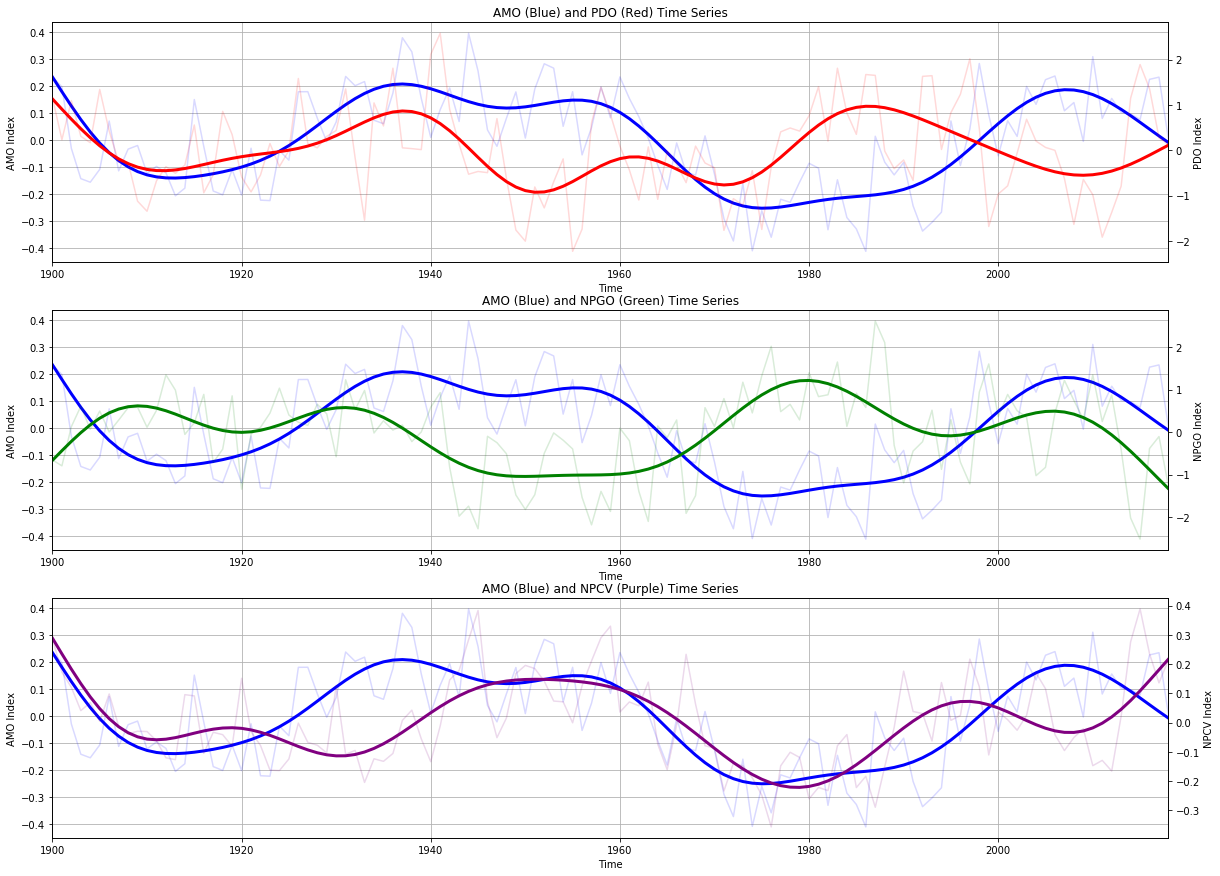

In [7]:
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(3,1,1)
ax.plot(sst_xr.year, amo, color='blue', linewidth=3)
ax.plot(sst_xr.year, amo_raw, color='blue', alpha=.15)
ax2=ax.twinx()
ax2.plot(sst_xr.year, pdo, color='red', linewidth=3)
ax2.plot(sst_xr.year, pdo_raw, color='red', alpha=.15)
ax.set_title('AMO (Blue) and PDO (Red) Time Series')
ax.set_xlabel('Time')
ax.set_xlim([1900,2018])
ax.set_ylabel('AMO Index')
ax2.set_ylabel('PDO Index')
ax.grid()

ax = fig.add_subplot(3,1,2)
ax.plot(sst_xr.year, amo, color='blue', linewidth=3)
ax.plot(sst_xr.year, amo_raw, color='blue', alpha=.15)
ax2=ax.twinx()
ax2.plot(sst_xr.year, npgo, color='green', linewidth=3)
ax2.plot(sst_xr.year, npgo_raw, color='green', alpha=.15)
ax.set_title('AMO (Blue) and NPGO (Green) Time Series')
ax.set_xlabel('Time')
ax.set_xlim([1900,2018])
ax.set_ylabel('AMO Index')
ax2.set_ylabel('NPGO Index')
ax.grid()

ax = fig.add_subplot(3,1,3)
ax.plot(sst_xr.year, amo, color='blue', linewidth=3)
ax.plot(sst_xr.year, amo_raw, color='blue', alpha=.15)
ax2=ax.twinx()
ax2.plot(sst_xr.year, npcv, color='purple', linewidth=3)
ax2.plot(sst_xr.year, npcv_raw, color='purple', alpha=.15)
ax.set_title('AMO (Blue) and NPCV (Purple) Time Series')
ax.set_xlabel('Time')
ax.set_xlim([1900,2018])
ax.set_ylabel('AMO Index')
ax2.set_ylabel('NPCV Index')
ax.grid()

plt.savefig(outdir + 'time_series.png', bbox_inches='tight')

Shown below is the cross correlation between the two time series above The dark, bold line is the cross correlation of filtered time series, while the gray, thin line is unfiltered. Note how filtering increases the peaks at -20 and 15 lag years dramatically. Also note the 0 correlation at 0 lag.

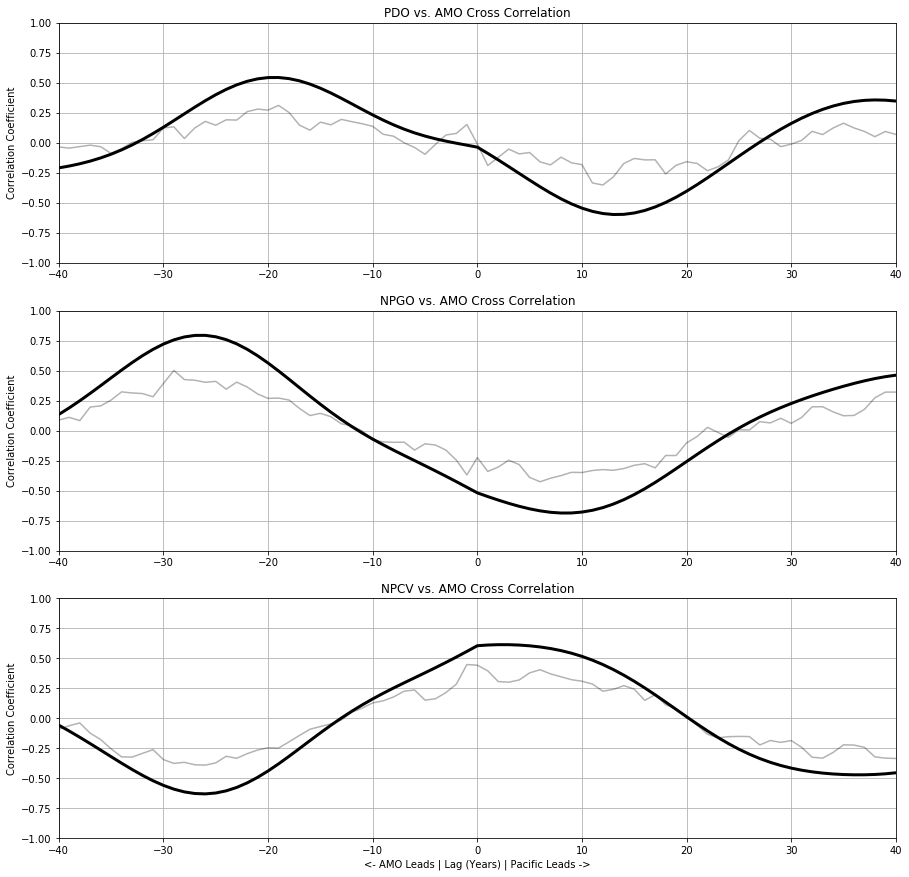

In [8]:
xcorr1 = plt.xcorr(pdo, amo, maxlags=40)
xcorr2 = plt.xcorr(pdo_raw, amo_raw, maxlags=40)
plt.close()
lags  = xcorr1[0]
corr1 = xcorr1[1]
corr2 = xcorr2[1]

xcorr3 = plt.xcorr(npgo, amo, maxlags=40)
xcorr4 = plt.xcorr(npgo_raw, amo_raw, maxlags=40)
plt.close()
corr3 = xcorr3[1]
corr4 = xcorr4[1]

xcorr5 = plt.xcorr(npcv, amo, maxlags=40)
xcorr6 = plt.xcorr(npcv_raw, amo_raw, maxlags=40)
plt.close()
corr5 = xcorr5[1]
corr6 = xcorr6[1]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(3,1,1)
ax.plot(lags, corr1, linewidth=3, color='black')
ax.plot(lags, corr2, color='black', alpha=.3)
ax.set_title('PDO vs. AMO Cross Correlation')
ax.set_xlim([-40,40])
ax.set_ylim([-1,1])
ax.set_ylabel('Correlation Coefficient')
ax.grid()

ax = fig.add_subplot(3,1,2)
ax.plot(lags, corr3, linewidth=3, color='black')
ax.plot(lags, corr4, color='black', alpha=.3)
ax.set_title('NPGO vs. AMO Cross Correlation')
ax.set_xlim([-40,40])
ax.set_ylim([-1,1])
ax.set_ylabel('Correlation Coefficient')
ax.grid()

ax = fig.add_subplot(3,1,3)
ax.plot(lags, corr5, linewidth=3, color='black')
ax.plot(lags, corr6, color='black', alpha=.3)
ax.set_title('NPCV vs. AMO Cross Correlation')
ax.set_xlabel('<- AMO Leads | Lag (Years) | Pacific Leads ->')
ax.set_xlim([-40,40])
ax.set_ylim([-1,1])
ax.set_ylabel('Correlation Coefficient')
ax.grid()

plt.savefig(outdir + 'xcorrs.png', bbox_inches='tight')

To show how the correlation can increase with time lags, the two peaks are shown below and clearly look more correlated than the original time series.

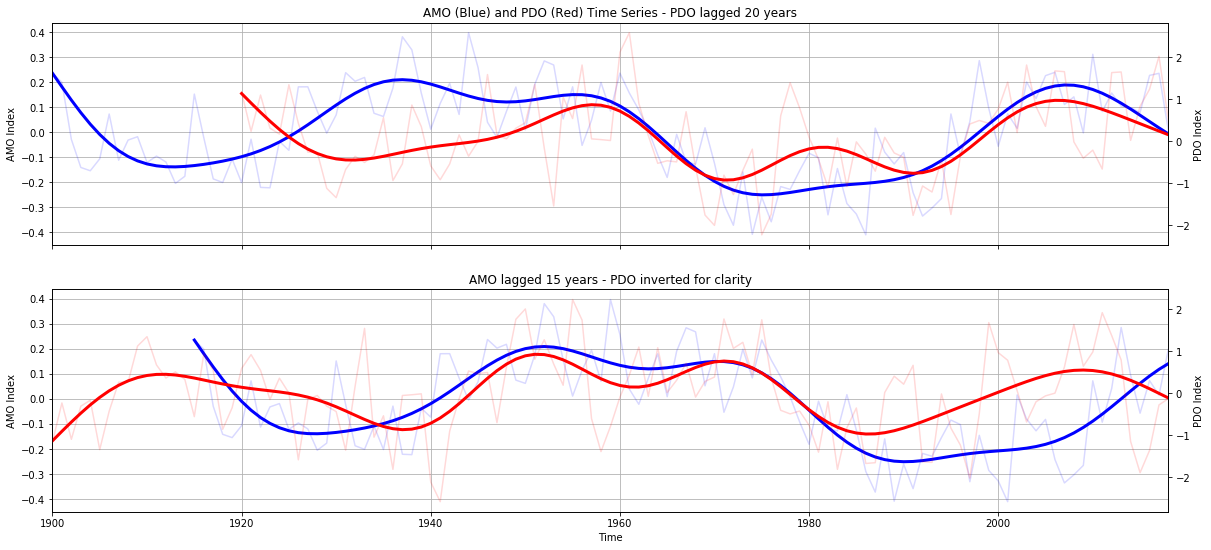

In [9]:
fig, ax0 = plt.subplots(nrows=2, ncols=1, figsize=(20,9), sharex=True)

ax = ax0[0]
ax.plot(sst_xr.year, amo, color='blue', linewidth=3)
ax.plot(sst_xr.year, amo_raw, color='blue', alpha=.15)
ax2=ax.twinx()
ax2.plot(sst_xr.year+20, pdo, color='red', linewidth=3)
ax2.plot(sst_xr.year+20, pdo_raw, color='red', alpha=.15)
ax.set_title('AMO (Blue) and PDO (Red) Time Series - PDO lagged 20 years')
ax.set_xlim([1900,2018])
ax.set_ylabel('AMO Index')
ax2.set_ylabel('PDO Index')
ax.grid()

ax = ax0[1]
ax.plot(sst_xr.year+15, amo, color='blue', linewidth=3)
ax.plot(sst_xr.year+15, amo_raw, color='blue', alpha=.15)
ax2=ax.twinx()
ax2.plot(sst_xr.year, -pdo, color='red', linewidth=3)
ax2.plot(sst_xr.year, -pdo_raw, color='red', alpha=.15)
ax.set_title('AMO lagged 15 years - PDO inverted for clarity')
ax.set_xlabel('Time')
ax.set_xlim([1900,2018])
ax.set_ylabel('AMO Index')
ax2.set_ylabel('PDO Index')
ax.grid()

plt.savefig(outdir + 'amo_pdo_shifted_time_series.png', bbox_inches='tight')

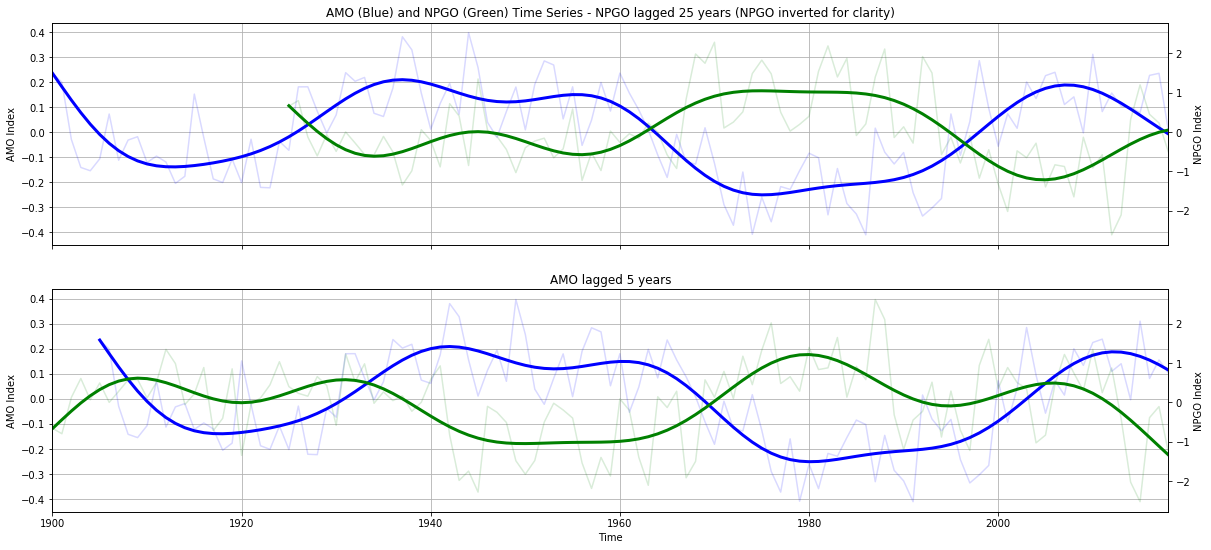

In [10]:
fig, ax0 = plt.subplots(nrows=2, ncols=1, figsize=(20,9), sharex=True)

ax = ax0[0]
ax.plot(sst_xr.year, amo, color='blue', linewidth=3)
ax.plot(sst_xr.year, amo_raw, color='blue', alpha=.15)
ax2=ax.twinx()
ax2.plot(sst_xr.year+25, -npgo, color='green', linewidth=3)
ax2.plot(sst_xr.year+25, -npgo_raw, color='green', alpha=.15)
ax.set_title('AMO (Blue) and NPGO (Green) Time Series - NPGO lagged 25 years (NPGO inverted for clarity)')
ax.set_xlim([1900,2018])
ax.set_ylabel('AMO Index')
ax2.set_ylabel('NPGO Index')
ax.grid()

ax = ax0[1]
ax.plot(sst_xr.year+5, amo, color='blue', linewidth=3)
ax.plot(sst_xr.year+5, amo_raw, color='blue', alpha=.15)
ax2=ax.twinx()
ax2.plot(sst_xr.year, npgo, color='green', linewidth=3)
ax2.plot(sst_xr.year, npgo_raw, color='green', alpha=.15)
ax.set_title('AMO lagged 5 years')
ax.set_xlabel('Time')
ax.set_xlim([1900,2018])
ax.set_ylabel('AMO Index')
ax2.set_ylabel('NPGO Index')
ax.grid()

plt.savefig(outdir + 'amo_npgo_shifted_time_series.png', bbox_inches='tight')

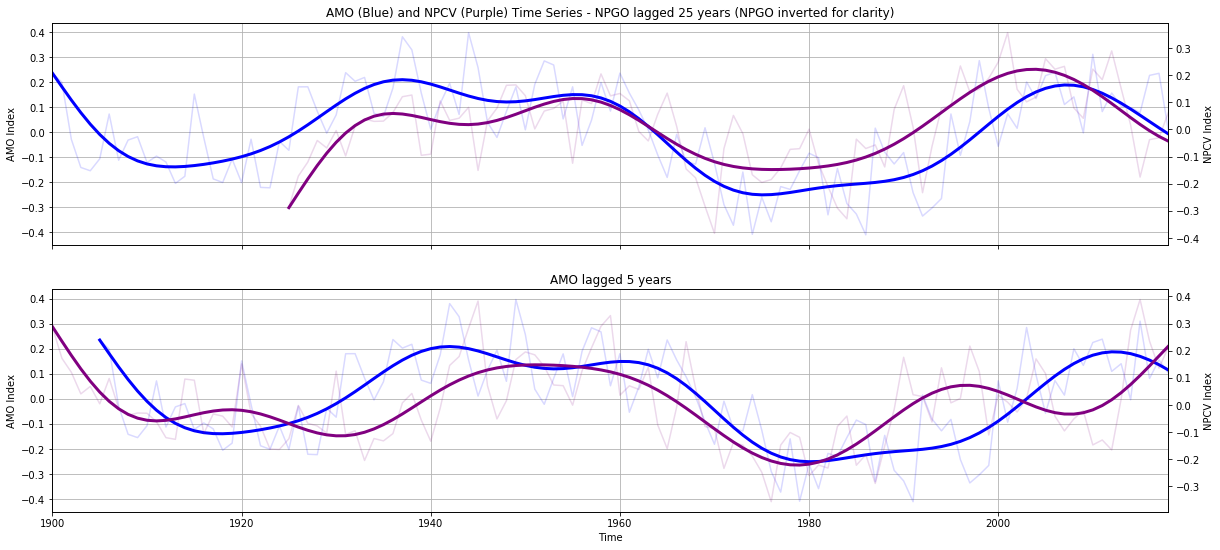

In [11]:
fig, ax0 = plt.subplots(nrows=2, ncols=1, figsize=(20,9), sharex=True)

ax = ax0[0]
ax.plot(sst_xr.year, amo, color='blue', linewidth=3)
ax.plot(sst_xr.year, amo_raw, color='blue', alpha=.15)
ax2=ax.twinx()
ax2.plot(sst_xr.year+25, -npcv, color='purple', linewidth=3)
ax2.plot(sst_xr.year+25, -npcv_raw, color='purple', alpha=.15)
ax.set_title('AMO (Blue) and NPCV (Purple) Time Series - NPGO lagged 25 years (NPGO inverted for clarity)')
ax.set_xlim([1900,2018])
ax.set_ylabel('AMO Index')
ax2.set_ylabel('NPCV Index')
ax.grid()

ax = ax0[1]
ax.plot(sst_xr.year+5, amo, color='blue', linewidth=3)
ax.plot(sst_xr.year+5, amo_raw, color='blue', alpha=.15)
ax2=ax.twinx()
ax2.plot(sst_xr.year, npcv, color='purple', linewidth=3)
ax2.plot(sst_xr.year, npcv_raw, color='purple', alpha=.15)
ax.set_title('AMO lagged 5 years')
ax.set_xlabel('Time')
ax.set_xlim([1900,2018])
ax.set_ylabel('AMO Index')
ax2.set_ylabel('NPCV Index')
ax.grid()

plt.savefig(outdir + 'amo_npcv_shifted_time_series.png', bbox_inches='tight')

Given this cross correlation and the two peaks shown, we want to test whether these peaks are statistically significant or not. Many methods exist for doing so, as we have learned in class, but they do not apply to every situation. A simple check of the filtered distributions can help me choose which methods to use:

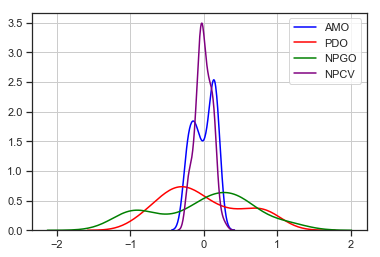

In [12]:
sns.set(style="ticks")
sns.distplot(amo,  label='AMO',  hist=False, color='blue')
sns.distplot(pdo,  label='PDO',  hist=False, color='red')
sns.distplot(npgo, label='NPGO', hist=False, color='green')
sns.distplot(npcv, label='NPCV', hist=False, color='purple')
plt.legend()
plt.grid()

plt.savefig(outdir + 'dists.png', bbox_inches='tight')

Given that neither of these distributions are normal or seem to fit any standard distributions, I will most likely need to utilize non-parametric statistics. One such method is known as the bootstrap method, which is a variation of the Monte Carlo method.

The Monte Carlo method involves generating a large number of synthetic runs to represent our data. These runs are typically created to have no meaning, so that anything "meaningful" from this synthetic data is simply spurious. If the data I am interested in is significantly different from these synthetic data runs, then it suggests that our actual data indeed has meaning (but it does not say for certain that it does!).

Bootstrapping is a variation of this in which the data is utilized itself and simply randomized, in order to preserve the distribution and range, among other parameters. It is simple to execute, generates white noise without deviating heavily from the data, and provides powerful information about where the true data falls amongst random time series.

Here, I use the raw time series, shuffle them 1000 times, and then filter them in the same way as the original time series. This gives me 1000 random AMO and PDO  time series, which I can cross correlate to generate test statistics.

In [13]:
def make_synthetic_data(index, n_runs=1000):
    ''''''
    
    syn_data_raw = np.zeros((n_runs, index.shape[0]))
    syn_data     = np.zeros(syn_data_raw.shape)
    
    for i in np.arange(n_runs):
        shuf              = random.sample(list(index), len(index))
        syn_data_raw[i,:] = shuf
        syn_data[i,:]     = scipy.signal.filtfilt(b, a, shuf)
    
    return syn_data_raw, syn_data


In [14]:
pdo_rand_raw,  pdo_rand  = make_synthetic_data(pdo_raw)
amo_rand_raw,  amo_rand  = make_synthetic_data(amo_raw)
npgo_rand_raw, npgo_rand = make_synthetic_data(npgo_raw)
npcv_rand_raw, npcv_rand = make_synthetic_data(npcv_raw)

In [15]:
rand_corrs1 = np.zeros((amo_rand.shape[0], 81))
rand_corrs2 = np.zeros((amo_rand.shape[0], 81))
rand_corrs3 = np.zeros((amo_rand.shape[0], 81))

for i in np.arange(amo_rand.shape[0]):
    xcorr1 = plt.xcorr(pdo_rand[i][5:-5],  amo_rand[i][5:-5], maxlags=40)
    xcorr2 = plt.xcorr(npgo_rand[i][5:-5], amo_rand[i][5:-5], maxlags=40)
    xcorr3 = plt.xcorr(npcv_rand[i][5:-5], amo_rand[i][5:-5], maxlags=40)
    plt.close()
    
    rand_corrs1[i,:] = xcorr1[1]
    rand_corrs2[i,:] = xcorr2[1]
    rand_corrs3[i,:] = xcorr3[1]

Shown below are 100 of the 1000 time series for the PDO and then the AMO. Note that the ends of many timie series are very sharp - this is an artifact of the filtering that occurs when a relatively high value ends up as an end point. To alleviate this problem, I simply lop off the first and last 5 years of every time series. The qualitative results are unaffected.

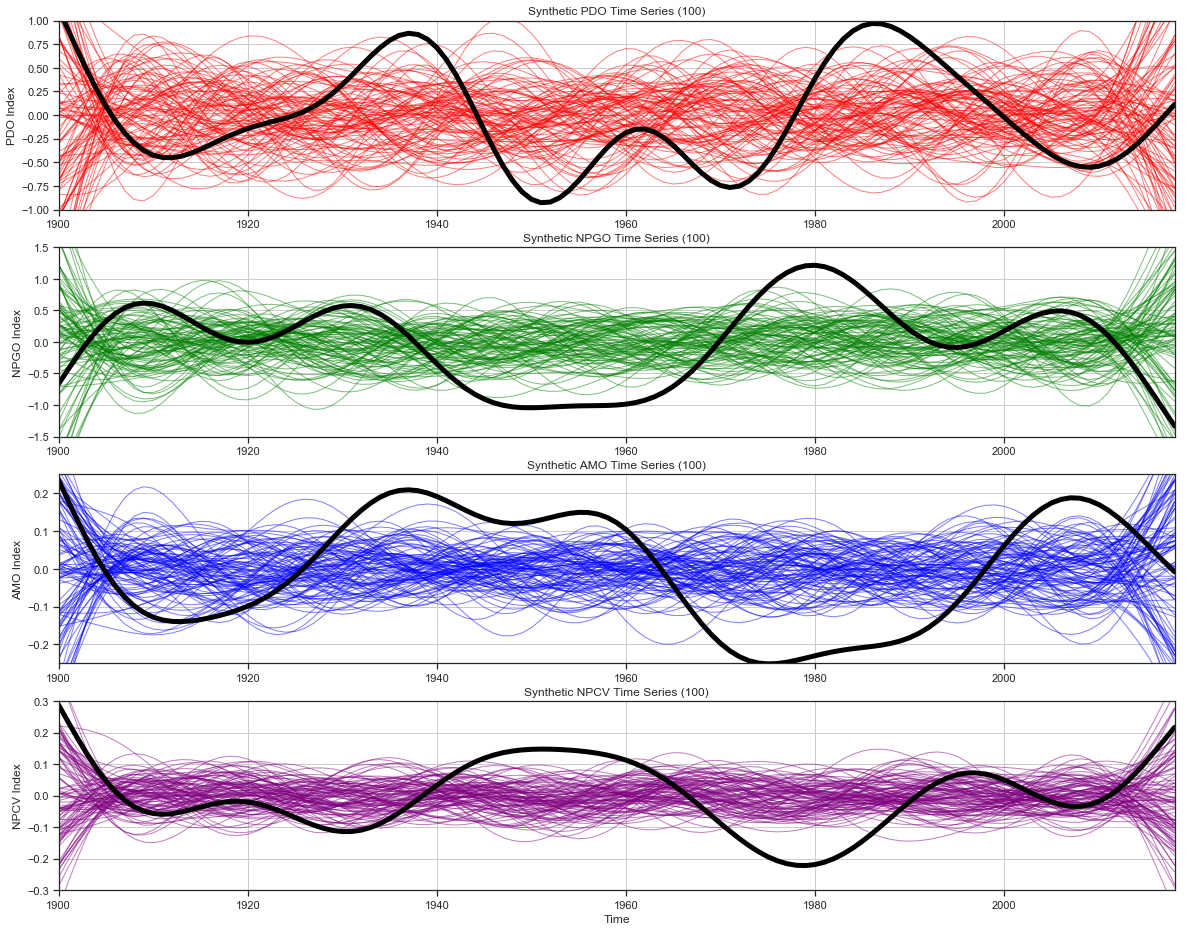

In [16]:
fig = plt.figure(figsize=(20, 16))

rands  = [pdo_rand, npgo_rand, amo_rand, npcv_rand]
obs0   = [pdo, npgo, amo, npcv]
colors = ['red', 'green', 'blue', 'purple']
ylims  = [[-1,1],[-1.5,1.5],[-.25,.25], [-.3,.3]]
names  = ['PDO', 'NPGO', 'AMO', 'NPCV']

for rand, obs, color, ylim, name, j in zip(rands, obs0, colors, ylims, names, np.arange(4)):
    
    ax = fig.add_subplot(4,1,j+1)
    
    for i in np.linspace(0, pdo_rand.shape[1], 100):
        ax.plot(sst_xr.year, rand[int(i),:], color=color, linewidth=1, alpha=.5)
        
    ax.plot(sst_xr.year, obs, color='black', linewidth=5)
    ax.set_title('Synthetic ' + name + ' Time Series (100)')
    ax.set_xlim([1900, 2018])
    ax.set_ylim(ylim)
    ax.set_ylabel(name + ' Index')
    ax.grid()
    
    if (j == 3):
        ax.set_xlabel('Time')

plt.savefig(outdir + 'synthetic_time_series.png', bbox_inches='tight')

Here, I show 12 randomly selected cross correlations from the above synthetic time series. Already, one can see that these have relatively high peaks that reach values comparable to that of the observed cross correlation. 

The typical method for using these to calculate statistical significance is to take the 95th (or whatever cutoff is preferred) percentile at each lag.

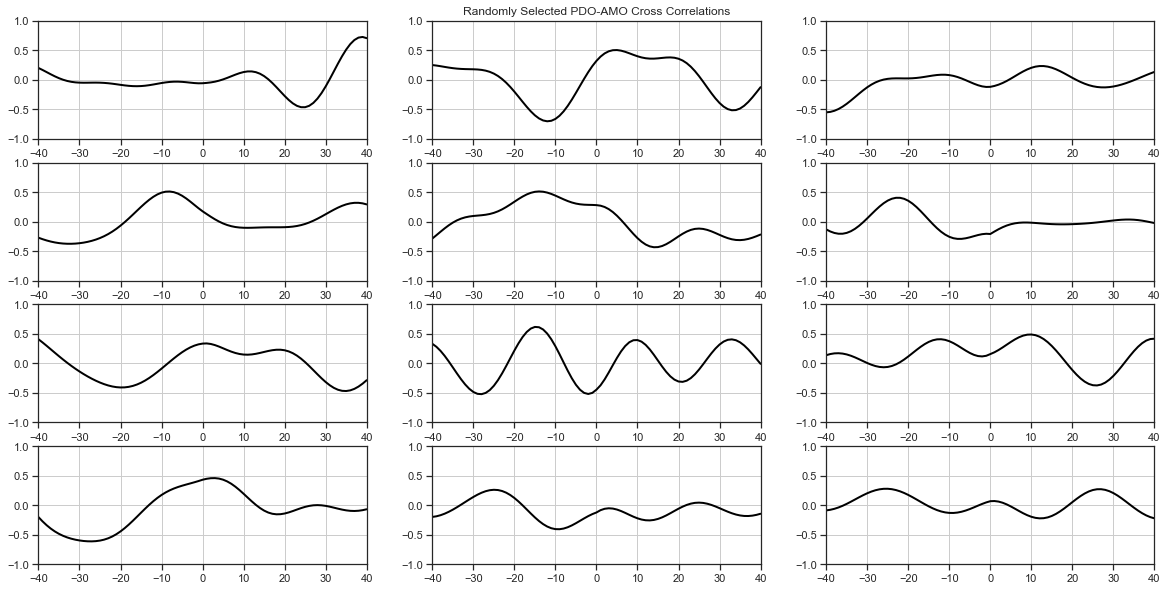

In [17]:
fig = plt.figure(figsize=(20,10))
for i, j in zip(np.linspace(0, rand_corrs1.shape[1], 12), np.arange(12)+1):
    i = int(i)
    ax = fig.add_subplot(4,3,j)
    ax.plot(lags, rand_corrs1[i,:], color='black', linewidth=2)
    ax.set_xlim([-40,40])
    ax.set_ylim([-1,1])
    ax.grid()
    if (j == 2):
        ax.set_title('Randomly Selected PDO-AMO Cross Correlations')
        
plt.savefig(outdir + 'amo_pdo_random_xcorrs.png', bbox_inches='tight')

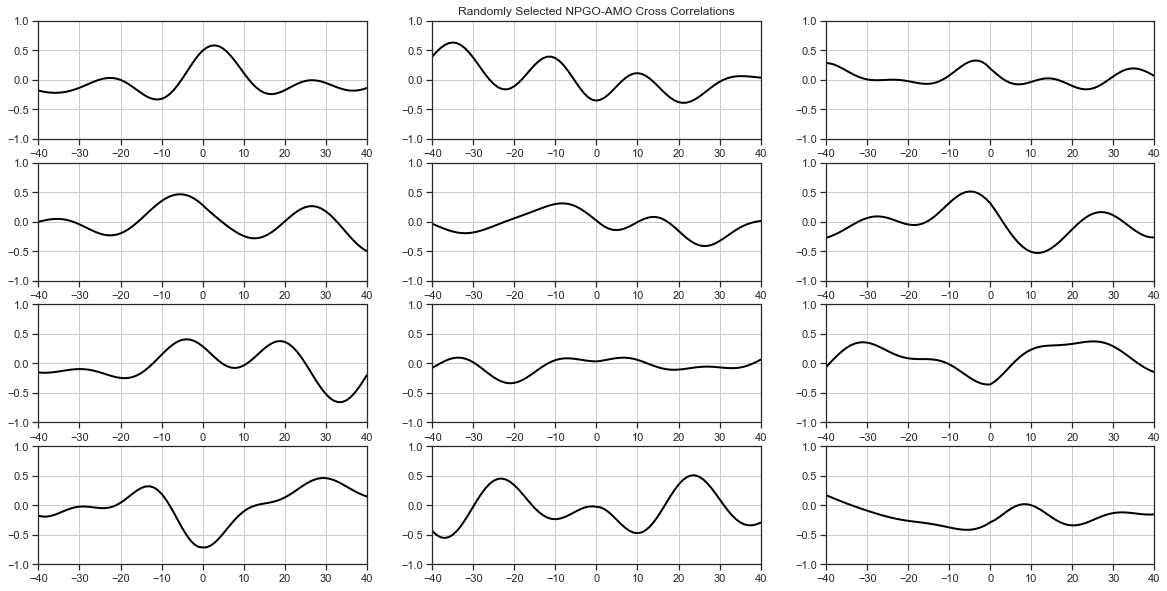

In [18]:
fig = plt.figure(figsize=(20,10))
for i, j in zip(np.linspace(0, rand_corrs2.shape[1], 12), np.arange(12)+1):
    i = int(i)
    ax = fig.add_subplot(4,3,j)
    ax.plot(lags, rand_corrs2[i,:], color='black', linewidth=2)
    ax.set_xlim([-40,40])
    ax.set_ylim([-1,1])
    ax.grid()
    if (j == 2):
        ax.set_title('Randomly Selected NPGO-AMO Cross Correlations')
        
plt.savefig(outdir + 'amo_npgo_random_xcorrs.png', bbox_inches='tight')

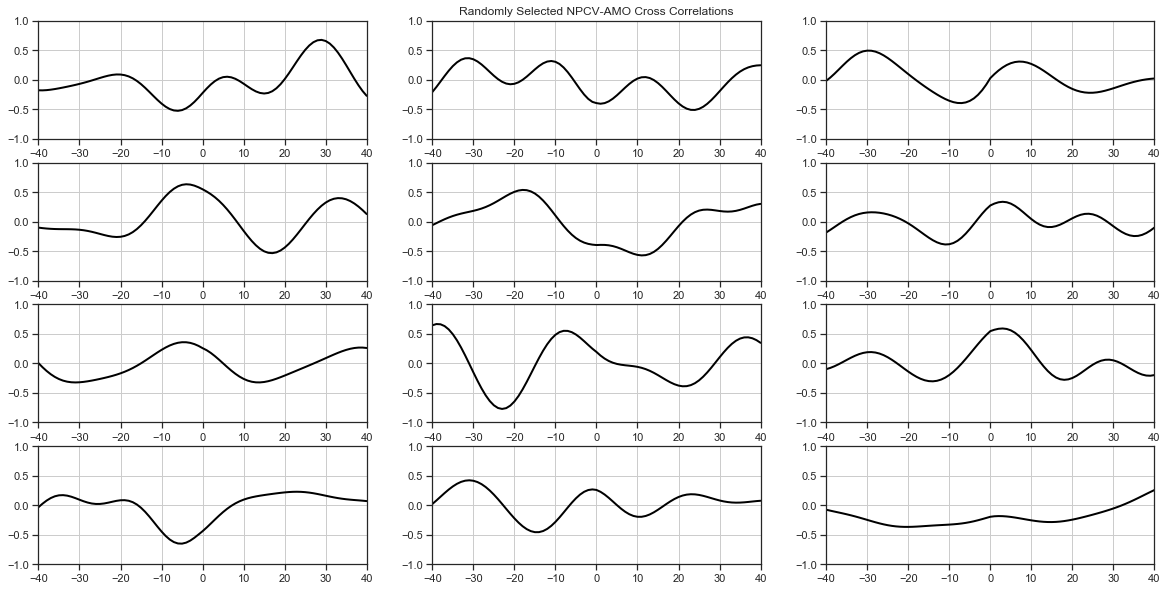

In [19]:
fig = plt.figure(figsize=(20,10))
for i, j in zip(np.linspace(0, rand_corrs3.shape[1], 12), np.arange(12)+1):
    i = int(i)
    ax = fig.add_subplot(4,3,j)
    ax.plot(lags, rand_corrs3[i,:], color='black', linewidth=2)
    ax.set_xlim([-40,40])
    ax.set_ylim([-1,1])
    ax.grid()
    if (j == 2):
        ax.set_title('Randomly Selected NPCV-AMO Cross Correlations')
        
plt.savefig(outdir + 'amo_npcv_random_xcorrs.png', bbox_inches='tight')

Doing so gives this result below, which suggests that the peak where the AMO leads by ~20 years is significant! The peak with the PDO leading by 15 years is very nearly significant as well. This is a great sign, right? I've now shown that these peaks are significant (or nearly so), and I can move on to determining a mechanism linking the two.

However... one issue here is that this assumes that the lead/lag at which the peaks occur is important. If they occurred at the same place in every synthetic cross correlation, this would be an acceptable method for significance testing. However, as shown above with only 12 synthetic cross correlations, there is no systematic pattern at which lead/lag the peaks occur. And this is what would be expected, given that these are random time series.

In [20]:
ss_lim1 = np.percentile(rand_corrs1, [2.5,97.5], axis=0)
ss_lim2 = np.percentile(rand_corrs2, [2.5,97.5], axis=0)
ss_lim3 = np.percentile(rand_corrs3, [2.5,97.5], axis=0)

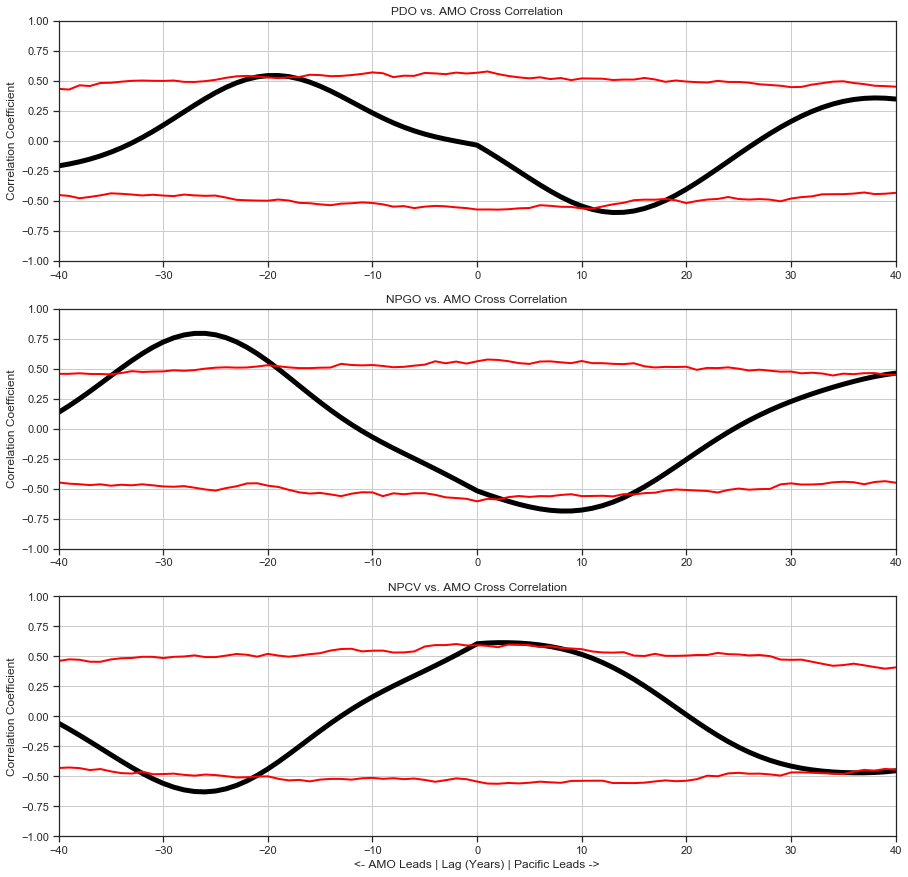

In [21]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(3,1,1)
ax.plot(lags, corr1, linewidth=5, color='black')
ax.plot(lags, ss_lim1[0,:], linewidth=2, color='red')
ax.plot(lags, ss_lim1[1,:], linewidth=2, color='red')
ax.set_title('PDO vs. AMO Cross Correlation')
ax.set_xlim([-40,40])
ax.set_ylim([-1,1])
ax.set_ylabel('Correlation Coefficient')
ax.grid()

ax = fig.add_subplot(3,1,2)
ax.plot(lags, corr3, linewidth=5, color='black')
ax.plot(lags, ss_lim2[0,:], linewidth=2, color='red')
ax.plot(lags, ss_lim2[1,:], linewidth=2, color='red')
ax.set_title('NPGO vs. AMO Cross Correlation')
ax.set_xlim([-40,40])
ax.set_ylim([-1,1])
ax.set_ylabel('Correlation Coefficient')
ax.grid()

ax = fig.add_subplot(3,1,3)
ax.plot(lags, corr5, linewidth=5, color='black')
ax.plot(lags, ss_lim3[0,:], linewidth=2, color='red')
ax.plot(lags, ss_lim3[1,:], linewidth=2, color='red')
ax.set_title('NPCV vs. AMO Cross Correlation')
ax.set_xlabel('<- AMO Leads | Lag (Years) | Pacific Leads ->')
ax.set_xlim([-40,40])
ax.set_ylim([-1,1])
ax.set_ylabel('Correlation Coefficient')
ax.grid()

plt.savefig(outdir + 'xcorrs_bad_test.png', bbox_inches='tight')

If we apply the same significance testing to the random cross correlations, a startling trend appears. In these 12 alone, 5 have significant peaks, and 2 more have nearly significant peaks.

And if I crunch some numbers quickly, I see that over 550 (!) or 55% of the 1000 random cross correlations would have statistically significant peaks. This clearly is not correct.

Instead, what is happening is that this test is moreso for each lead/lag as opposed to each time series. If I test how many points (out of 81000) are significant, the results are much closer to what is expected - just over 6% of all points are significant here.

But with each cross correlation containing 81 points, it can be expected that roughly 4 points per cross correlation would be significant at the 95th percentile. And indeed, that is what seemingly occurs here.

So, it is now obvious that I need to use a different method for significance testing.

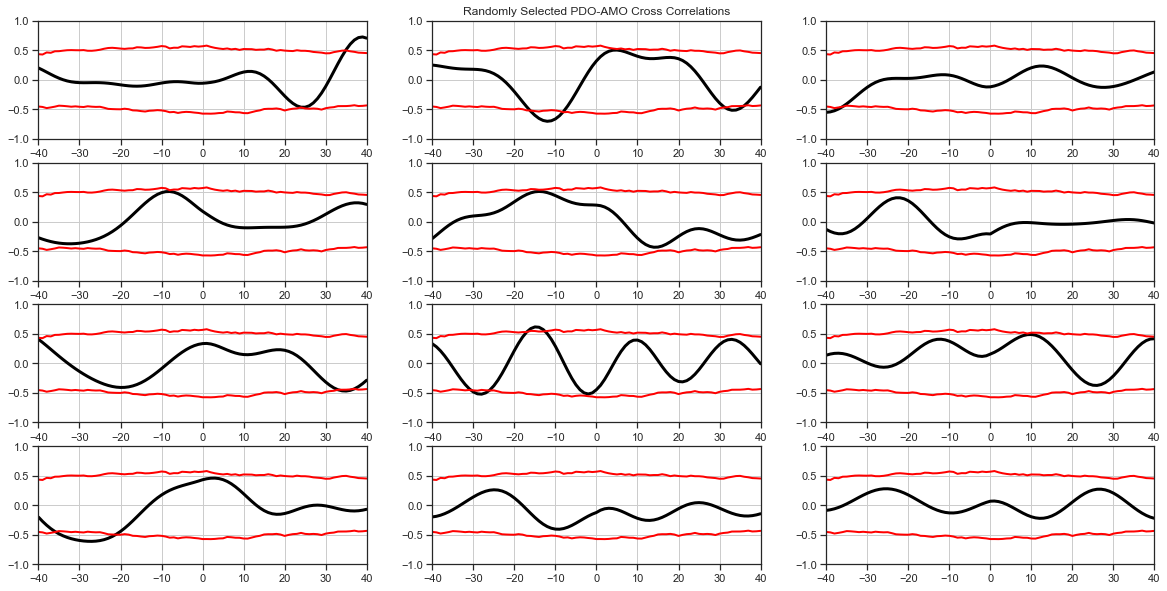

In [22]:
fig = plt.figure(figsize=(20,10))
for i, j in zip(np.linspace(0, rand_corrs1.shape[1], 12), np.arange(12)+1):
    i = int(i)
    ax = fig.add_subplot(4,3,j)
    ax.plot(lags, rand_corrs1[i,:], linewidth=3, color='black')
    ax.set_xlim([-40,40])
    ax.set_ylim([-1,1])
    ax.plot(lags, ss_lim1[0,:], linewidth=2, color='red')
    ax.plot(lags, ss_lim1[1,:], linewidth=2, color='red')
    ax.grid()
    if (j == 2):
        ax.set_title('Randomly Selected PDO-AMO Cross Correlations')
        
plt.savefig(outdir + 'amo_pdo_random_xcorrs_bad_test.png', bbox_inches='tight')

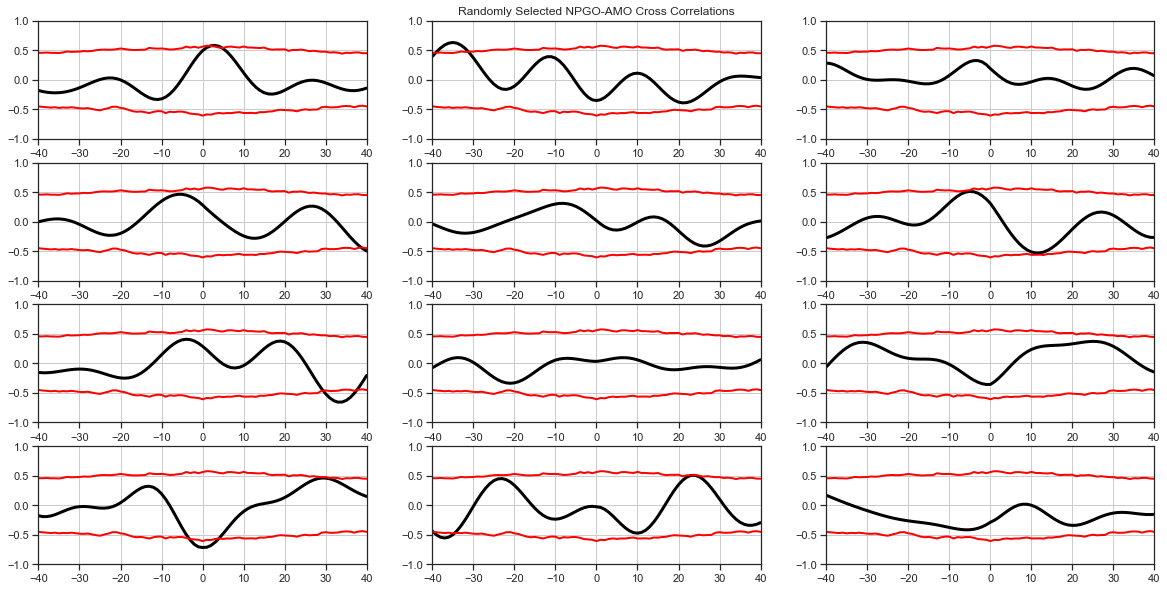

In [23]:
fig = plt.figure(figsize=(20,10))
for i, j in zip(np.linspace(0, rand_corrs2.shape[1], 12), np.arange(12)+1):
    i = int(i)
    ax = fig.add_subplot(4,3,j)
    ax.plot(lags, rand_corrs2[i,:], linewidth=3, color='black')
    ax.set_xlim([-40,40])
    ax.set_ylim([-1,1])
    ax.plot(lags, ss_lim2[0,:], linewidth=2, color='red')
    ax.plot(lags, ss_lim2[1,:], linewidth=2, color='red')
    ax.grid()
    if (j == 2):
        ax.set_title('Randomly Selected NPGO-AMO Cross Correlations')
        
plt.savefig(outdir + 'amo_npgo_random_xcorrs_bad_test.png', bbox_inches='tight')

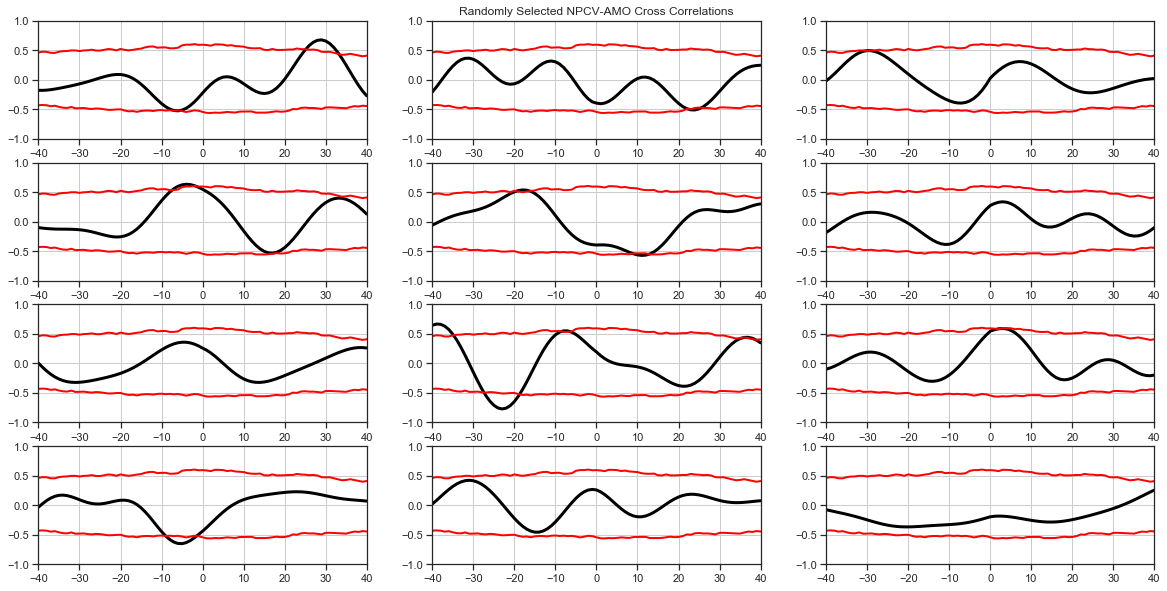

In [24]:
fig = plt.figure(figsize=(20,10))
for i, j in zip(np.linspace(0, rand_corrs3.shape[1], 12), np.arange(12)+1):
    i = int(i)
    ax = fig.add_subplot(4,3,j)
    ax.plot(lags, rand_corrs3[i,:], linewidth=3, color='black')
    ax.set_xlim([-40,40])
    ax.set_ylim([-1,1])
    ax.plot(lags, ss_lim3[0,:], linewidth=2, color='red')
    ax.plot(lags, ss_lim3[1,:], linewidth=2, color='red')
    ax.grid()
    if (j == 2):
        ax.set_title('Randomly Selected NPCV-AMO Cross Correlations')
        
plt.savefig(outdir + 'amo_npcv_random_xcorrs_bad_test.png', bbox_inches='tight')

In [25]:
total1 = 0
total2 = 0
total3 = 0

for i in np.arange(rand_corrs1.shape[0]):
    if (np.any(rand_corrs1[i] > ss_lim1[1])):
        total1 = total1 + 1
    elif (np.any(rand_corrs1[i] < ss_lim1[0])):
        total1 = total1 + 1
        
for i in np.arange(rand_corrs2.shape[0]):
    if (np.any(rand_corrs2[i] > ss_lim2[1])):
        total2 = total2 + 1
    elif (np.any(rand_corrs2[i] < ss_lim2[0])):
        total2 = total2 + 1
        
for i in np.arange(rand_corrs3.shape[0]):
    if (np.any(rand_corrs3[i] > ss_lim3[1])):
        total3 = total3 + 1
    elif (np.any(rand_corrs3[i] < ss_lim3[0])):
        total3 = total3 + 1
        
print(total1, '(', total1/10, '%) Random PDO-AMO cross correlations with statistically significant peaks!')
print(total2, '(', total2/10, '%) Random NPGO-AMO cross correlations with statistically significant peaks!')
print(total3, '(', total3/10, '%) Random NPCV-AMO cross correlations with statistically significant peaks!')

578 ( 57.8 %) Random PDO-AMO cross correlations with statistically significant peaks!
553 ( 55.3 %) Random NPGO-AMO cross correlations with statistically significant peaks!
576 ( 57.6 %) Random NPCV-AMO cross correlations with statistically significant peaks!


In [26]:
total1 = 0
total2 = 0
total3 = 0

for i in np.arange(rand_corrs1.shape[0]):
    for j in np.arange(rand_corrs1.shape[1]):
        if (rand_corrs1[i,j] > ss_lim1[1,j]):
            total1 = total1 + 1
        elif (rand_corrs1[i,j] < ss_lim1[0,j]):
            total1 = total1 + 1
            
for i in np.arange(rand_corrs2.shape[0]):
    for j in np.arange(rand_corrs2.shape[1]):
        if (rand_corrs2[i,j] > ss_lim2[1,j]):
            total2 = total2 + 1
        elif (rand_corrs2[i,j] < ss_lim2[0,j]):
            total2 = total2 + 1
            
for i in np.arange(rand_corrs3.shape[0]):
    for j in np.arange(rand_corrs3.shape[1]):
        if (rand_corrs3[i,j] > ss_lim3[1,j]):
            total3 = total3 + 1
        elif (rand_corrs3[i,j] < ss_lim3[0,j]):
            total3 = total3 + 1
        
print(total1, '(', total1/810, '%) PDO-AMO cross correlation statistically significant points!')
print(total2, '(', total2/810, '%) NPGO-AMO cross correlation statistically significant points!')
print(total3, '(', total3/810, '%) NPCV-AMO cross correlation statistically significant points!')

4050 ( 5.0 %) PDO-AMO cross correlation statistically significant points!
4050 ( 5.0 %) NPGO-AMO cross correlation statistically significant points!
4050 ( 5.0 %) NPCV-AMO cross correlation statistically significant points!


Since I am interested in only the peaks, it would be logical to do significance testing using only the peaks!

This actually is quite simple to do - just find the minimum and maximum of each cross correlation, which gives 1000 maximums and 1000 minimums. Then, just take the 95th percentile of these positive and negative peaks (where the correlation is the strongest). Instead of a jagged line that varies with the lead/lag, I now have a straight line for the entire cross correlation, and it is at a much stronger correlation than before.

As seen below, there is now only 1 of 12 cross correlations with a significant peak, much closer to what is expected. And out of all 1000, only 49 (almost exactly 5%) have significant peaks.

This seems much more accurate and gives a much more rigorous threshold that actually tests what I am interested in now.

In [27]:
ss_ulim1 = np.percentile(np.max(rand_corrs1, axis=1), 99.5)
ss_llim1 = np.percentile(np.min(rand_corrs1, axis=1),  .5)

ss_ulim2 = np.percentile(np.max(rand_corrs2, axis=1), 99.5)
ss_llim2 = np.percentile(np.min(rand_corrs2, axis=1), .5)

ss_ulim3 = np.percentile(np.max(rand_corrs3, axis=1), 99.5)
ss_llim3 = np.percentile(np.min(rand_corrs3, axis=1), .5)

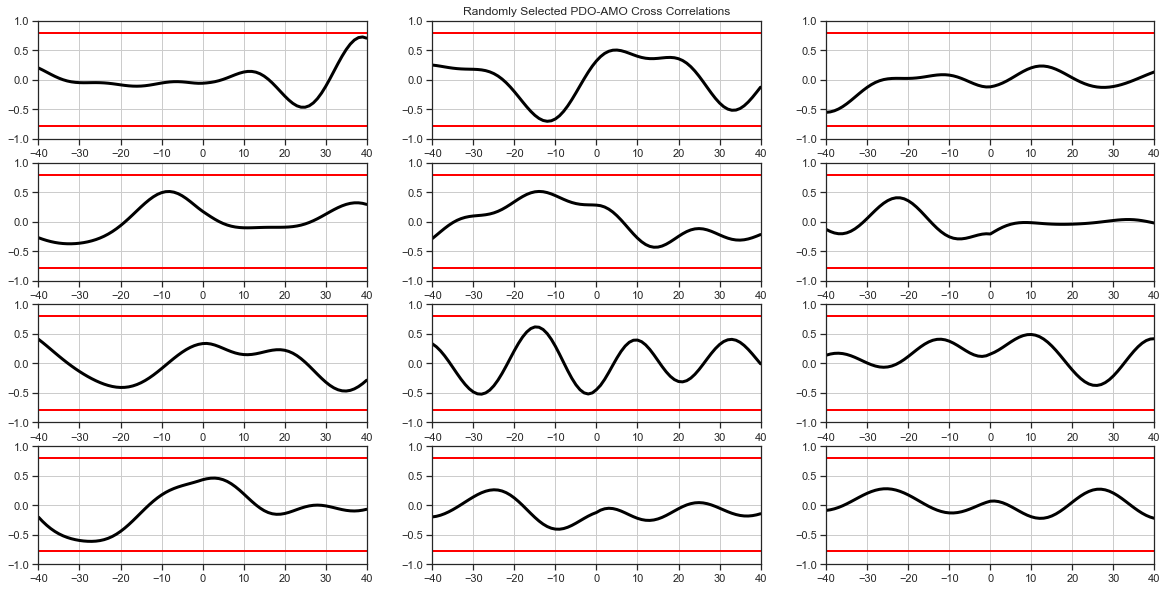

In [28]:
fig = plt.figure(figsize=(20,10))
for i, j in zip(np.linspace(0, rand_corrs1.shape[1], 12), np.arange(12)+1):
    i = int(i)
    ax = fig.add_subplot(4,3,j)
    ax.plot(lags, rand_corrs1[i,:], linewidth=3, color='black')
    ax.set_xlim([-40,40])
    ax.set_ylim([-1,1])
    ax.plot(lags, [ss_ulim1]*81, linewidth=2, color='red')
    ax.plot(lags, [ss_llim1]*81, linewidth=2, color='red')
    ax.grid()
    if (j == 2):
        ax.set_title('Randomly Selected PDO-AMO Cross Correlations')
        
plt.savefig(outdir + 'amo_pdo_random_xcorrs_good_test.png', bbox_inches='tight')

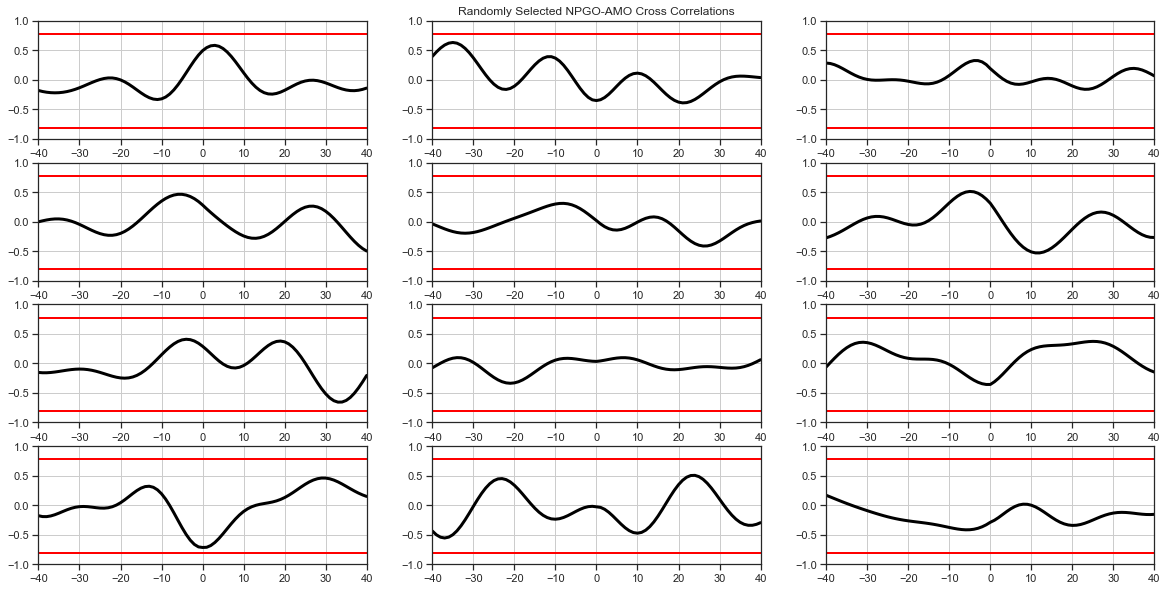

In [29]:
fig = plt.figure(figsize=(20,10))
for i, j in zip(np.linspace(0, rand_corrs2.shape[1], 12), np.arange(12)+1):
    i = int(i)
    ax = fig.add_subplot(4,3,j)
    ax.plot(lags, rand_corrs2[i,:], linewidth=3, color='black')
    ax.set_xlim([-40,40])
    ax.set_ylim([-1,1])
    ax.plot(lags, [ss_ulim2]*81, linewidth=2, color='red')
    ax.plot(lags, [ss_llim2]*81, linewidth=2, color='red')
    ax.grid()
    if (j == 2):
        ax.set_title('Randomly Selected NPGO-AMO Cross Correlations')
        
plt.savefig(outdir + 'amo_npgo_random_xcorrs_good_test.png', bbox_inches='tight')

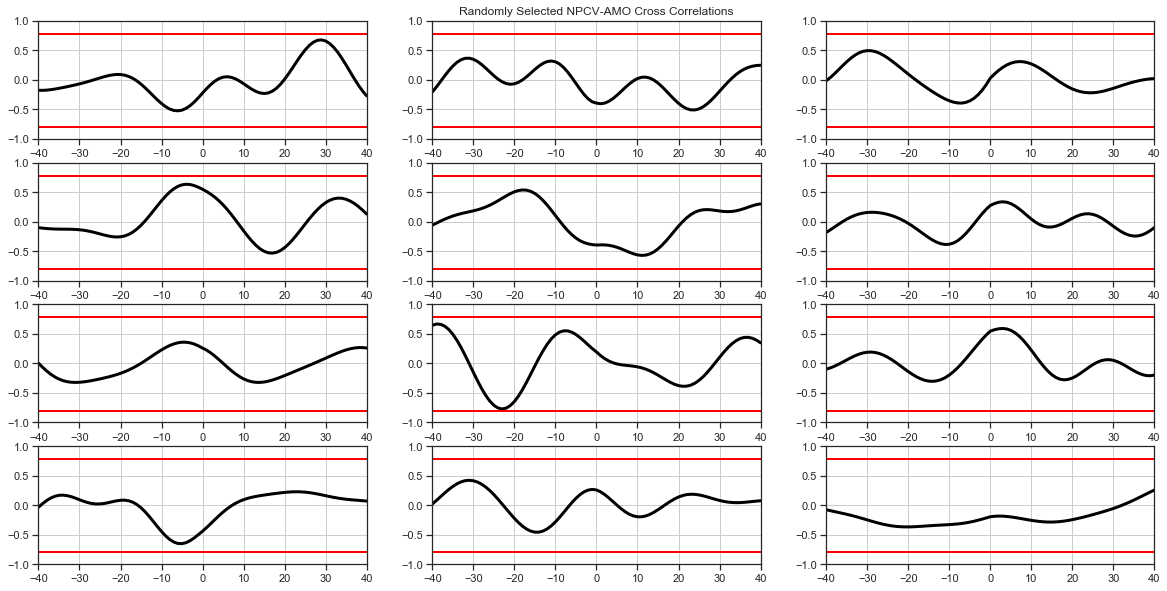

In [30]:
fig = plt.figure(figsize=(20,10))
for i, j in zip(np.linspace(0, rand_corrs3.shape[1], 12), np.arange(12)+1):
    i = int(i)
    ax = fig.add_subplot(4,3,j)
    ax.plot(lags, rand_corrs3[i,:], linewidth=3, color='black')
    ax.set_xlim([-40,40])
    ax.set_ylim([-1,1])
    ax.plot(lags, [ss_ulim3]*81, linewidth=2, color='red')
    ax.plot(lags, [ss_llim3]*81, linewidth=2, color='red')
    ax.grid()
    if (j == 2):
        ax.set_title('Randomly Selected NPCV-AMO Cross Correlations')
        
plt.savefig(outdir + 'amo_npcv_random_xcorrs_good_test.png', bbox_inches='tight')

In [31]:
total1 = 0
total2 = 0
total3 = 0

for i in np.arange(rand_corrs1.shape[0]):
    if (np.any(rand_corrs1[i] > ss_ulim1)):
        total1 = total1 + 1
    elif (np.any(rand_corrs1[i] < ss_llim1)):
        total1 = total1 + 1

for i in np.arange(rand_corrs2.shape[0]):
    if (np.any(rand_corrs2[i] > ss_ulim2)):
        total2 = total2 + 1
    elif (np.any(rand_corrs2[i] < ss_llim2)):
        total2 = total2 + 1

for i in np.arange(rand_corrs3.shape[0]):
    if (np.any(rand_corrs3[i] > ss_ulim3)):
        total3 = total3 + 1
    elif (np.any(rand_corrs3[i] < ss_llim3)):
        total3 = total3 + 1
        
print(total1, '(', total1/10, '%) PDO-AMO cross correlations with statistically significant peaks!')
print(total2, '(', total2/10, '%) NPGO-AMO cross correlations with statistically significant peaks!')
print(total3, '(', total3/10, '%) NPCV-AMO cross correlations with statistically significant peaks!')

10 ( 1.0 %) PDO-AMO cross correlations with statistically significant peaks!
10 ( 1.0 %) NPGO-AMO cross correlations with statistically significant peaks!
10 ( 1.0 %) NPCV-AMO cross correlations with statistically significant peaks!


And now, it becomes clear that the observed cross correlation is not significant. While this does not definitely say that there is no link between these two basins (especially because the PDO only captures ~25-35% of North Pacific variance), it is evidence strongly against that claim.

Other variations of this can be done. AR1 red noise (Markov processes) can be used instead of bootstrapping, although the results are qualitatively similar (I have neglected to do this here for simplicity and time). Other modes (the 2nd principal component in the North Pacific, for instance) can be used too. 

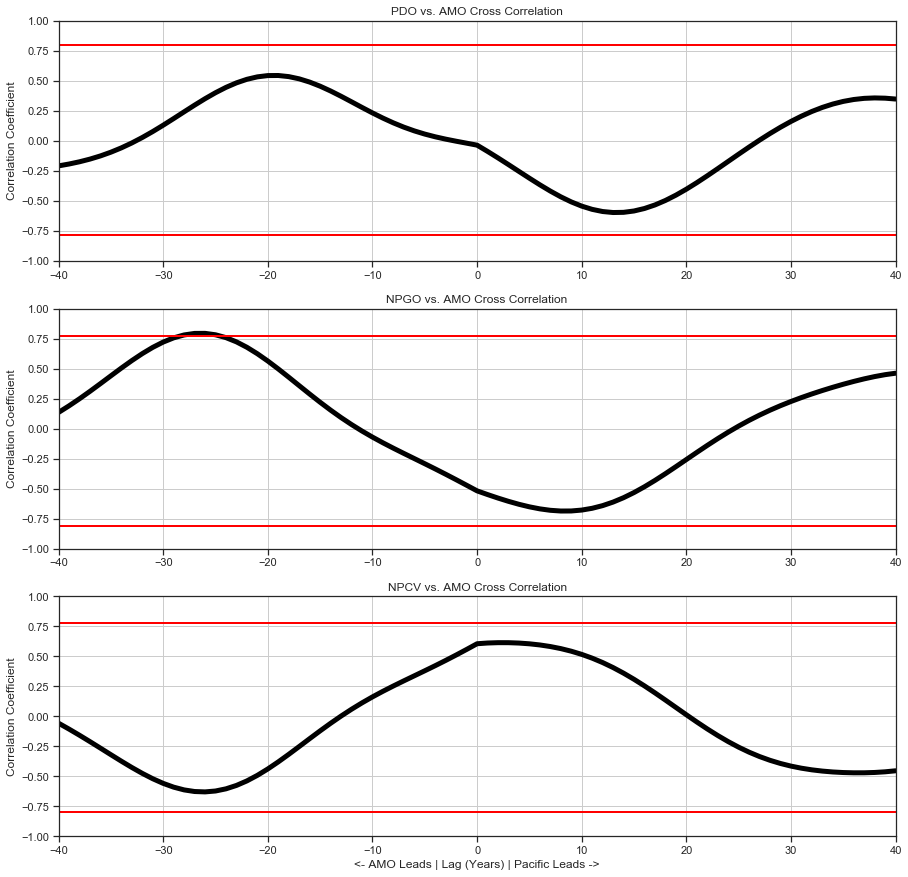

In [32]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(3,1,1)
ax.plot(lags, corr1, linewidth=5, color='black')
ax.plot(lags, [ss_ulim1] * 81, linewidth=2, color='red')
ax.plot(lags, [ss_llim1] * 81, linewidth=2, color='red')
ax.set_title('PDO vs. AMO Cross Correlation')
ax.set_xlim([-40,40])
ax.set_ylim([-1,1])
ax.set_ylabel('Correlation Coefficient')
ax.grid()

ax = fig.add_subplot(3,1,2)
ax.plot(lags, corr3, linewidth=5, color='black')
ax.plot(lags, [ss_ulim2] * 81, linewidth=2, color='red')
ax.plot(lags, [ss_llim2] * 81, linewidth=2, color='red')
ax.set_title('NPGO vs. AMO Cross Correlation')
ax.set_xlim([-40,40])
ax.set_ylim([-1,1])
ax.set_ylabel('Correlation Coefficient')
ax.grid()

ax = fig.add_subplot(3,1,3)
ax.plot(lags, corr5, linewidth=5, color='black')
ax.plot(lags, [ss_ulim3] * 81, linewidth=2, color='red')
ax.plot(lags, [ss_llim3] * 81, linewidth=2, color='red')
ax.set_title('NPCV vs. AMO Cross Correlation')
ax.set_xlabel('<- AMO Leads | Lag (Years) | Pacific Leads ->')
ax.set_xlim([-40,40])
ax.set_ylim([-1,1])
ax.set_ylabel('Correlation Coefficient')
ax.grid()

plt.savefig(outdir + 'xcorrs_good_test.png', bbox_inches='tight')

Bonus (if there's time):
       
While this notebook has worked exclusively in correlation space thus far, variance space is easier to visualize. It is simply the square of the correlations, and it removes the positive/negative aspects, making percentile calculations a bit less tricky. It is also easier to visualize: see below for an example.

Here, the strongest correlation for each synthetic time series is shown as variance (the squared maximum of the absolute value of cross correlations). The large black X represents the observations. The red line is the threshold for 95% significance. The observations are clearly well within the cloud of random noise, and it is readily apparent that it is not significant.

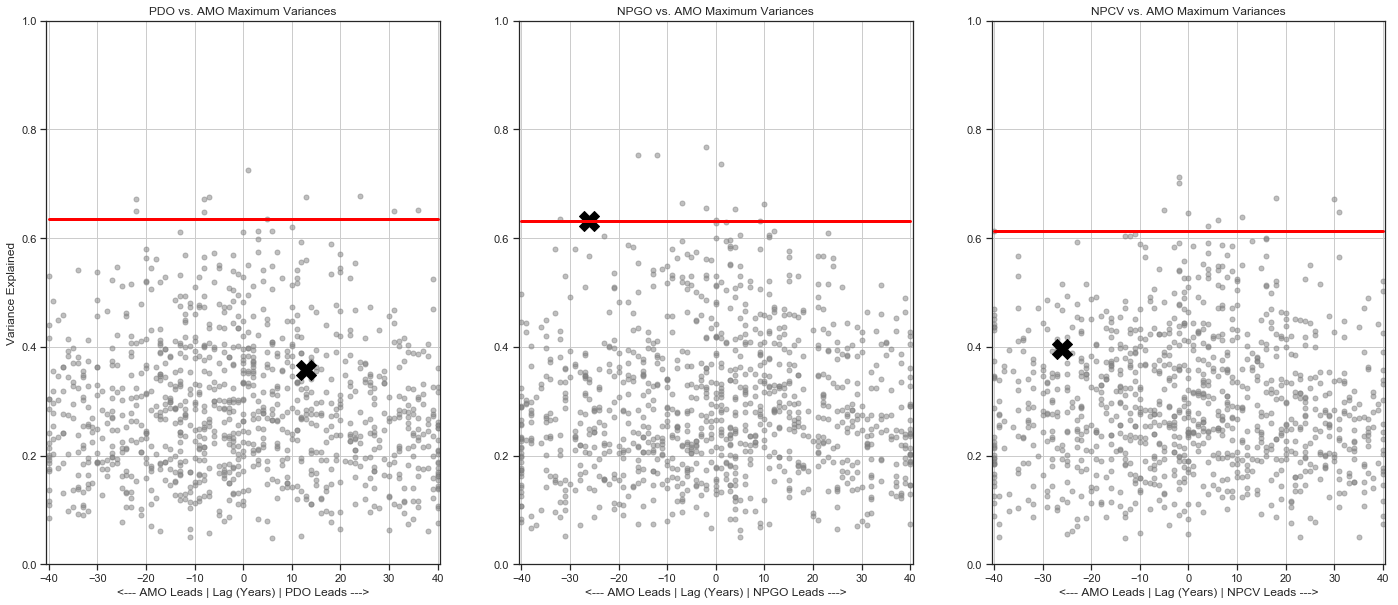

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,10))

ax[0].set_ylim((0,1))
ax[0].set_xlim((-40.5, 40.5))
ax[0].grid()

ax[1].set_ylim((0,1))
ax[1].set_xlim((-40.5, 40.5))
ax[1].grid()

ax[2].set_ylim((0,1))
ax[2].set_xlim((-40.5, 40.5))
ax[2].grid()

varis1         = rand_corrs1**2
max_varis1     = np.max(varis1, axis=1)
max_varis_idx1 = np.argmax(varis1, axis=1)
perc_95_varis1 = np.percentile(max_varis1, 99)

ax[0].scatter(lags[max_varis_idx1], max_varis1, color='gray', marker='.', s=100, alpha=.5)
ax[0].plot(lags, [perc_95_varis1]*81, color='red', linewidth=3)

idx1 = np.argmax(corr1**2)
ax[0].scatter(lags[idx1], corr1[idx1]**2, color='black', marker='X', s=400)

ax[0].set_xlabel('<--- AMO Leads | Lag (Years) | PDO Leads --->')
ax[0].set_ylabel('Variance Explained')
ax[0].set_title('PDO vs. AMO Maximum Variances')


varis2         = rand_corrs2**2
max_varis2     = np.max(varis2, axis=1)
max_varis_idx2 = np.argmax(varis2, axis=1)
perc_95_varis2 = np.percentile(max_varis2, 99)

ax[1].scatter(lags[max_varis_idx2], max_varis2, color='gray', marker='.', s=100, alpha=.5)
ax[1].plot(lags, [perc_95_varis2]*81, color='red', linewidth=3)

idx2 = np.argmax(corr3**2)
ax[1].scatter(lags[idx2], corr3[idx2]**2, color='black', marker='X', s=400)

ax[1].set_xlabel('<--- AMO Leads | Lag (Years) | NPGO Leads --->')
ax[1].set_title('NPGO vs. AMO Maximum Variances')


varis3         = rand_corrs3**2
max_varis3     = np.max(varis3, axis=1)
max_varis_idx3 = np.argmax(varis3, axis=1)
perc_95_varis3 = np.percentile(max_varis3, 99)

ax[2].scatter(lags[max_varis_idx3], max_varis3, color='gray', marker='.', s=100, alpha=.5)
ax[2].plot(lags, [perc_95_varis3]*81, color='red', linewidth=3)

idx3 = np.argmax(corr5**2)
ax[2].scatter(lags[idx3], corr5[idx3]**2, color='black', marker='X', s=400)

ax[2].set_xlabel('<--- AMO Leads | Lag (Years) | NPCV Leads --->')
ax[2].set_title('NPCV vs. AMO Maximum Variances')

plt.savefig(outdir + 'scatter_vars.png', bbox_inches='tight')